In [147]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
import torchvision.transforms.functional as TF
import random
import matplotlib.pyplot as plt
import os
from torchvision.io import read_image, write_jpeg
from torch.utils.data import Dataset
import torch
import sys
from collections import defaultdict
from tqdm import tqdm


def load_labels(path):
    df = pd.read_csv(path)
    return df


def load_image(path, idx, df):
    img_path = os.path.join(path, df.iloc[idx, 0] + '.jpg')
    image = read_image(img_path)

    return image


def transform_image(image):
    angle = random.randint(-180, 180)
    image = TF.rotate(image, angle)
    
    hflip_prob = random.randint(1, 10)
    if hflip_prob > 5:
        image = TF.hflip(image)
    
    vflip_prob = random.randint(1, 10)
    if vflip_prob > 5:
        image = TF.vflip(image)

    return image


def show_image(image):
    plt.imshow(  image.permute(1, 2, 0)  )
    
    
def append_df(df, labels):
    highest_idx = len(df) - 1
    
    # Sanity Check
    img_number = int(df.iloc[highest_idx]['image_name'].split('_')[1])
    if highest_idx != img_number:
        print(f"[-] We got out of sync at index {highest_idx}")
        print(f"{df.iloc[highest_idx]}")
        sys.exit(-1)
        
    new_idx = highest_idx + 1    
    new_row = {
        "image_name": [f"augment_{new_idx}"],
        "tags": [' '.join(labels)]
    }
    return_row = {
        "image_name": f"augment_{new_idx}",
        "tags": ' '.join(labels)
    }
    
    new_df = pd.concat([df, pd.DataFrame.from_dict(new_row)], ignore_index=True)
    return new_df, return_row


def save_image(base_path, img_name, img):
    path = os.path.join(base_path, img_name)
    write_jpeg(img, path, 100)

    
def get_labels(df, idx):
    labels = df.iloc[idx]['tags']
    return labels.strip().split(' ')


def get_score(labels, dist, max_val):
    label_scores = []
    for label in labels:
        label_scores += [ dist[label] ]
    
    #score = 0
    #for ls in label_scores:
        # normalize [0, 1]
    #    score += ls / max_val
    most_common = max(label_scores)
    rarest = min(label_scores)
    
    score = (1 - most_common) * (1 - rarest)
    
    return score


def get_label_dist(df):
    tags = ['haze', 'primary', 'agriculture', 'clear', 'water', 'habitation', 'road', 'cultivation', 'slash_burn',
         'cloudy', 'partly_cloudy', 'conventional_mine', 'bare_ground', 'artisinal_mine', 'blooming',
         'selective_logging', 'blow_down']
    
    dist = defaultdict(int)
    for idx in range(len(df)):
        labels = df.iloc[idx]['tags'].strip().split(' ')
        for l in labels:
            dist[l] += 1
    
    for t in tags:
        dist[t] = dist[t] / len(df)
    
    return dist, sum(dist.values())
    
def show_dist(df, title):
    fig = plt.figure(figsize=(7,5))
    ax = fig.add_axes([0,0,1,1])
    tags = list(df.keys())
    rate = list(df.values())
    bars = ax.bar(tags, rate)
    ax.set_ylabel('rate',fontsize= 12)
    ax.set_xlabel('tags',fontsize= 12)
    ax.set_xticklabels(tags, rotation=90)
    ax.set_title(title) 
    
    ax.bar_label(bars,[round(r*100, 2) for r in rate])

    plt.show()

    
def main():
    base_path = '/home/gro/Documents/Uni/Erasmus/Vorlesungen/DLVR/Project/datasets/deeplearningproject/'
    
    csv_path = os.path.join(base_path, "train_classes.csv")
    img_base_path = os.path.join(base_path, "train-jpg")

    df = load_labels(csv_path)
    label_dist, max_val = get_label_dist(df)
    len_df = len(df)
    
    counter = 0
    for idx in tqdm(range(len_df)):
        trans_tags = df.iloc[idx]['tags'].split(' ')
        if get_score(trans_tags, label_dist, max_val) < 0.3:
            continue
        
        if df.iloc[idx]['image_name'].startswith('augment'):
            continue

        img = load_image(img_base_path, idx, df)
        for i in range(15):
            trans_img = transform_image(img)[:3,:,:]
            df, new_row = append_df(df, trans_tags)
        
            save_image(img_base_path, f"{new_row['image_name']}.jpg", trans_img)
            counter += 1

    with open(os.path.join(base_path, 'new_classes.csv'), 'w') as f:
        f.write(df.to_csv(index=False))
    
    print(f"Augmented {counter} images")

    df_new = load_labels(os.path.join(base_path, "new_classes.csv"))
    label_dist_new, max_val_new = get_label_dist(df_new)
    show_dist(label_dist, 'tag_distrib_old')
    show_dist(label_dist_new, 'tag_distrib_new')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40479/40479 [02:58<00:00, 227.03it/s]


Augmented 33045 images


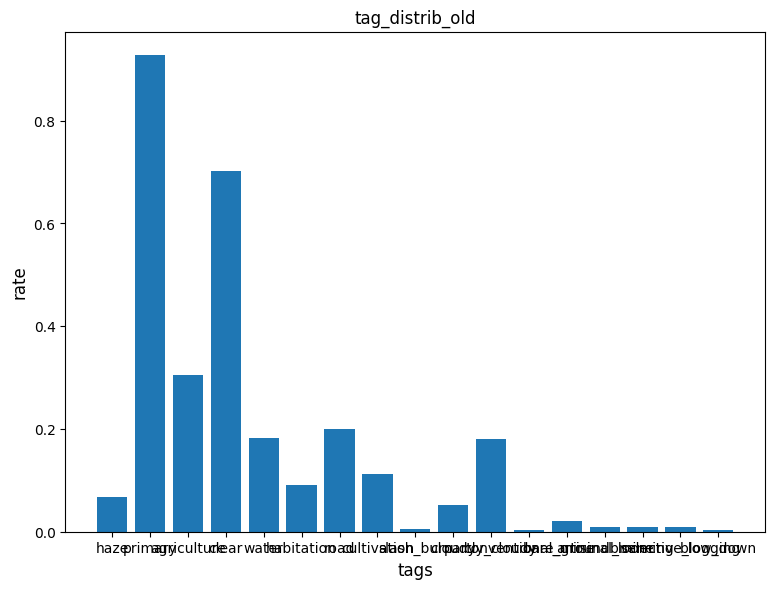

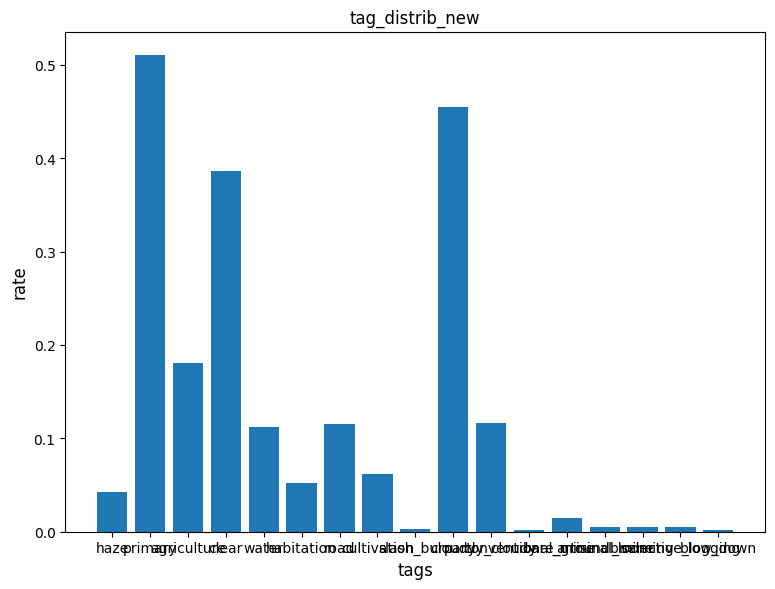

/tmp/ipykernel_76898/1206404975.py:121: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(tags, rotation=90)


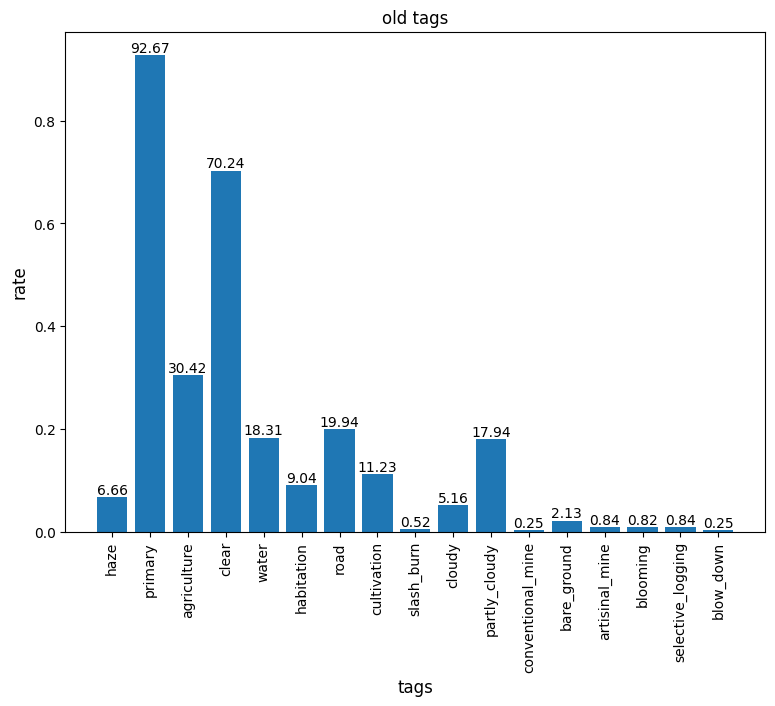

/tmp/ipykernel_76898/1206404975.py:121: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(tags, rotation=90)


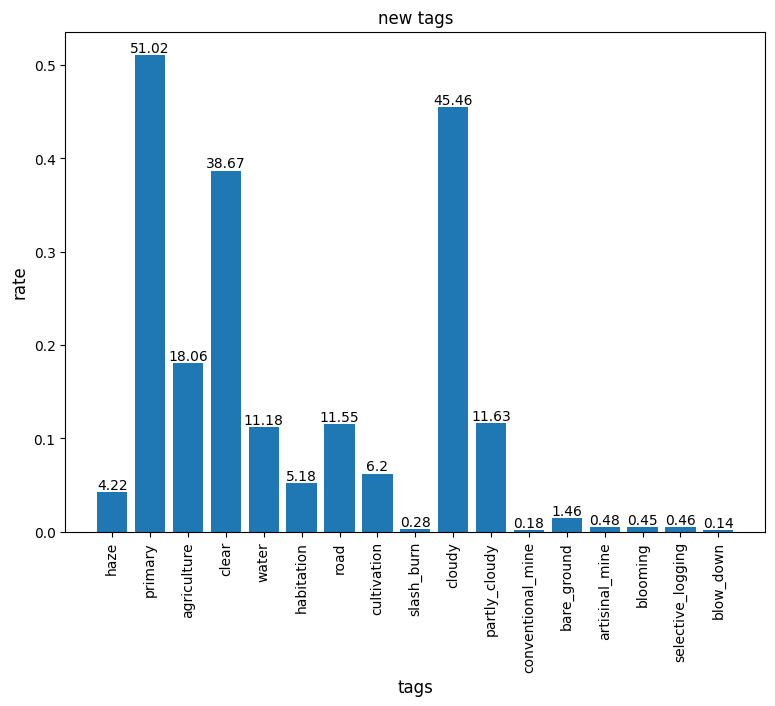

In [148]:
    base_path = '/home/gro/Documents/Uni/Erasmus/Vorlesungen/DLVR/Project/datasets/deeplearningproject/'
    
    csv_path = os.path.join(base_path, "train_classes.csv")
    img_base_path = os.path.join(base_path, "train-jpg")

    df = load_labels(csv_path)
    label_dist, max_val = get_label_dist(df)
    
    df_new = load_labels(os.path.join(base_path, "new_classes.csv"))
    label_dist_new, max_val_new = get_label_dist(df_new)
    show_dist(label_dist, 'old tags')
    show_dist(label_dist_new, 'new tags')

In [123]:
main()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40479/40479 [02:49<00:00, 239.44it/s]


Augmented 31581 images


In [107]:
base_path = '/home/gro/Documents/Uni/Erasmus/Vorlesungen/DLVR/Project/datasets/deeplearningproject/'
df = load_labels(os.path.join(base_path, 'new_classes.csv'))
list(df.columns)
#get_label_dist(df)


['image_name', 'tags']

In [74]:
print(df.iloc[-2:])

          image_name                                           tags
40478    train_40478  agriculture cultivation partly_cloudy primary
40479  augment_40479  agriculture cultivation partly_cloudy primary


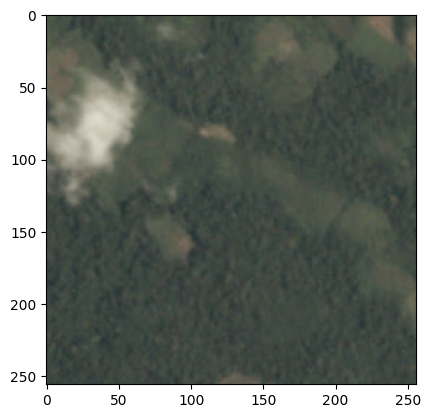

In [76]:
old_img = load_image(os.path.join(base_path, "train-jpg"), 40478, df)
new_img = load_image(os.path.join(base_path, "train-jpg"), 40479, df)

plt.imshow(  old_img.permute(1, 2, 0)  )